### Install package

In [1]:
!pip uninstall -y pyreflect

In [ ]:
!pip install -i https://test.pypi.org/simple/ pyreflect==1.1.2

In [1]:
!pip show pyreflect

Name: pyreflect
Version: 1.1.2
Summary: The package tool for neutron reflectivity analysis
Home-page: https://github.com/williamQyq/pyreflect
Author: Yuqing Qiao
Author-email: qiao.yuqi@northeastern.edu
License: MIT
Location: /home/qiao.yuqi/.conda/envs/PT_env/lib/python3.11/site-packages
Requires: llvmlite, matplotlib, numba, numpy, opencv-python, pandas, pyyaml, refl1d, scikit-learn, scipy, seaborn, torch, torchvision, tqdm, typer
Required-by: 


In [ ]:
!python -m pyreflect init --force

In [3]:
import pyreflect
from pyreflect.config import load_config
import pyreflect.flows as workflow
from pyreflect.input import NRSLDDataProcessor

import pandas as pd
from pathlib import Path
from pprint import pprint

Selected device for model training: cuda


In [4]:
#load config
root = "./"
# root = Path("./")

config = pyreflect.config.load_config(root)
pprint(config)

{'nr_predict_sld': {'file': {'experimental_nr_file': 'data/curves/expt_nr.npy',
                             'nr_curves_poly': 'data/curves/nr_curves_poly.npy',
                             'sld_curves_poly': 'data/curves/sld_curves_poly.npy'},
                    'models': {'batch_size': 32,
                               'epochs': 10,
                               'model': 'data/curves/trained_nr_sld_model.pth',
                               'num_curves': 50000}},
 'sld_predict_chi': {'file': {'model_chi_params_file': 'data/mod_params_fp49.npy',
                              'model_experimental_sld_profile': 'data/mod_expt.npy',
                              'model_sld_file': 'data/mod_sld_fp49.npy'},
                     'models': {'ae_epochs': 20,
                                'batch_size': 16,
                                'latent_dim': 2,
                                'mlp_epochs': 20}}}


## Load Data

In [7]:
# Experimental NR data
expt_nr_file = "./data/curves/expt_nr.npy"
expt_sld_file = "./data/curves/expt_sld.npy"

# Data processor
data_proc = NRSLDDataProcessor(nr_file_path=expt_nr_file,sld_file_path=expt_sld_file)
data_proc.load_data()

norm_nr = data_proc.normalize_nr()
norm_sld = data_proc.normalize_sld()

norm_nr.shape, norm_sld.shape

((100, 2, 308), (100, 2, 900))

### Model Training and Prediction

In [8]:
y_pred_all = pyreflect.flows.run_sld_prediction(root, config)
y_pred_all.shape

No trained SLD model found. Training a new model...
Generating Curves for training...


/home/qiao.yuqi/.conda/envs/PT_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing reflectivity


Processing reflectivity curves: 100%|██████████| 50000/50000 [01:31<00:00, 548.10it/s]


processed NR shape:(50000, 2, 308)

processed SLD shape:(50000, 2, 900)
NR SLD generated curves saved at: 
               mod sld file: data/curves/sld_curves_poly.npy
                mod nr file: data/curves/nr_curves_poly.npy
Training model using curves...
Epoch 1/10 - Train Loss: 0.002594, Validation Loss: 0.001535
Epoch 2/10 - Train Loss: 0.001233, Validation Loss: 0.001491
Epoch 3/10 - Train Loss: 0.001086, Validation Loss: 0.000966
Epoch 4/10 - Train Loss: 0.000984, Validation Loss: 0.000975
Epoch 5/10 - Train Loss: 0.000942, Validation Loss: 0.001003
Epoch 6/10 - Train Loss: 0.000885, Validation Loss: 0.000995
Epoch 7/10 - Train Loss: 0.000846, Validation Loss: 0.000810
Epoch 8/10 - Train Loss: 0.000826, Validation Loss: 0.000742
Epoch 9/10 - Train Loss: 0.000775, Validation Loss: 0.000788
Epoch 10/10 - Train Loss: 0.000766, Validation Loss: 0.000726
NR predict SLD trained CNN model saved at: data/curves/trained_nr_sld_model.pth
Loading NR SLD model...
Running SLD Prediction...


(100, 2, 900)

### Plotting check

In [9]:
import matplotlib.pyplot as plt

def plot_experiment_results(expt_nr_data, predicted_sld, expt_sld_data=None):
    """
    Plots experimental NR data separately and overlays experimental SLD with predicted SLD if available.

    Parameters:
        expt_nr_data (np.ndarray): Experimental Neutron Reflectivity data, shape (2, *).
        predicted_sld (np.ndarray): Predicted SLD profile, shape (2, *).
        expt_sld_data (np.ndarray, optional): Experimental SLD profile, shape (2, *). Default is None.

    Notes:
        - expt_nr_data[0] is Q (wave vector), expt_nr_data[1] is Reflectivity.
        - predicted_sld[0] is Depth (Å), predicted_sld[1] is SLD values.
        - expt_sld_data is only plotted if provided.
    """

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Two side-by-side plots

    # Left Plot: Experimental NR (Reflectivity vs. Q)
    axes[0].plot(expt_nr_data[0], expt_nr_data[1], 'b-', label="Experimental NR", alpha=0.7)
    axes[0].set_xlabel("Q (1/Å)")  # Wave vector transfer
    axes[0].set_ylabel("Reflectivity", color="blue")
    axes[0].set_yscale("log")  # Reflectivity is usually in log scale
    axes[0].set_title("Experimental NR Data")
    axes[0].legend()

    # Right Plot: Predicted SLD vs. Experimental SLD (if available)
    if expt_sld_data is not None:
        axes[1].plot(expt_sld_data[0], expt_sld_data[1], 'r-', label="Experimental SLD", linewidth=2)

    axes[1].plot(predicted_sld[0], predicted_sld[1], 'g--', label="Predicted SLD", linewidth=2)
    
    axes[1].set_xlabel("Depth (Å)")
    axes[1].set_ylabel("Scattering Length Density (SLD) [10⁻⁶ Å⁻²]")
    axes[1].set_title("SLD Profile & Prediction")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


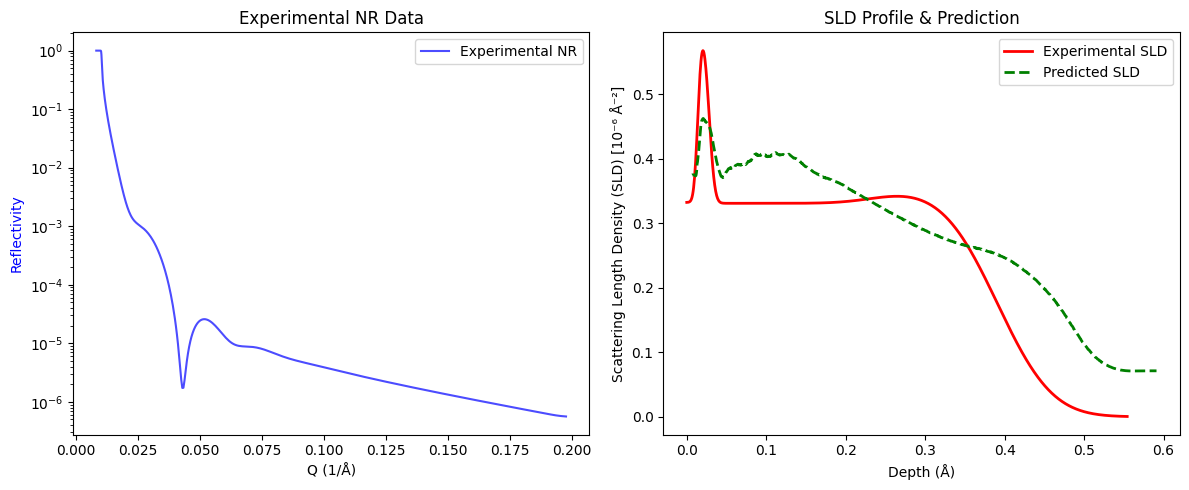

In [10]:
expt_nr = data_proc._nr_arr[0]
expt_sld = norm_sld[0]

y_pred = y_pred_all[0]

# Plotting
plot_experiment_results(expt_nr,y_pred,expt_sld)

### Real Experimental Data check

In [ ]:
# import numpy as np
# expt_nr_data = "./npoutputs2/np_out_REFL_194385_combined_data_auto.npy"
# data = np.load(expt_nr_data)
# data.shape

In [ ]:
# !pip install gdown

In [ ]:
# import gdown
# gdown.download_folder("https://drive.google.com/drive/folders/1lBIo_aC1yRNW2SYuyzCq7vQOFO0M3DYo")